In [6]:
import os
import pickle

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, Input
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

In [8]:
picture_size = 48
batch_size = 64
folder_path = "/kaggle/input/fer-final/FER_CNN/FER_CNN/"
print(os.listdir(folder_path))  
checkpoint_path = "/kaggle/working/model_checkpoint_epoch_{epoch:02d}.h5"
history_path = "/kaggle/working/training_history.pkl"
no_of_classes = 6

['test', 'train']


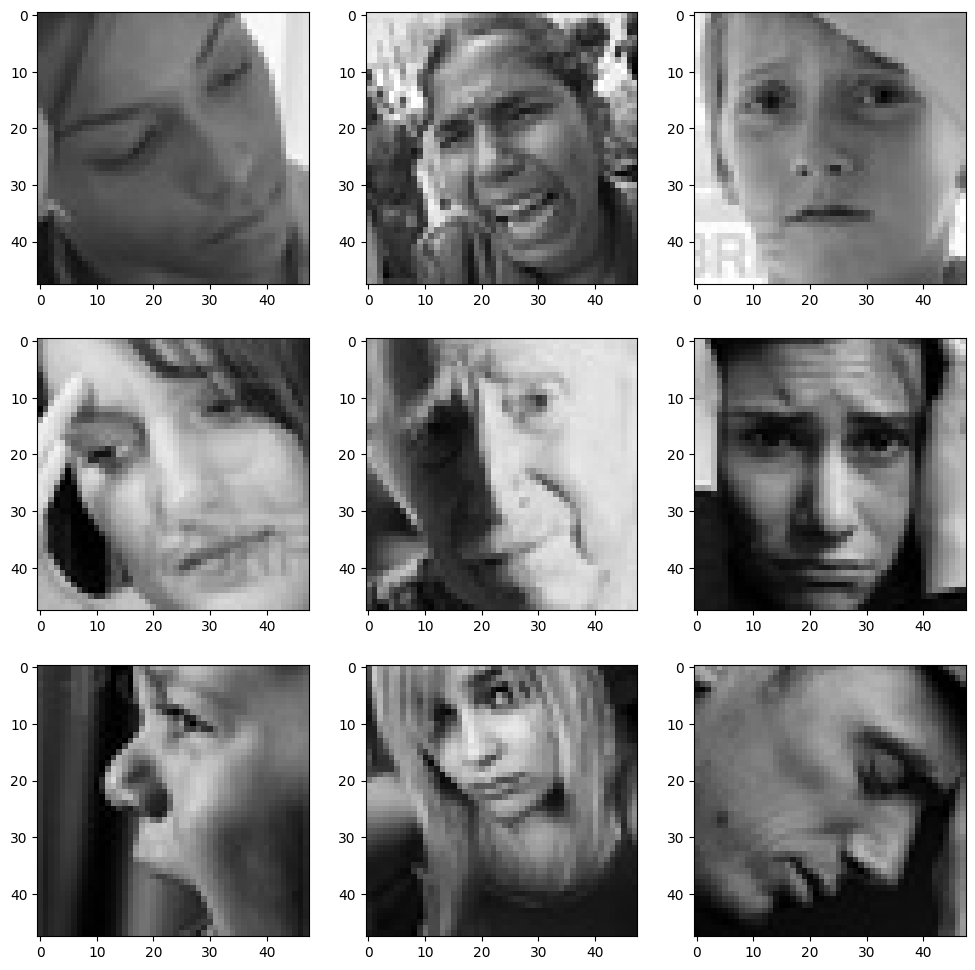

In [8]:
expression = 'sad'
plt.figure(figsize=(12, 12))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)
    # Construct the correct image path
    img_path = os.path.join(folder_path, "train", expression, os.listdir(os.path.join(folder_path, "train", expression))[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [9]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = datagen_val.flow_from_directory(
    folder_path + "test",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 18264 images belonging to 6 classes.
Found 4566 images belonging to 6 classes.


In [11]:
# Model architecture
emotion_model = Sequential()

# First Convolutional Block
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce spatial size
emotion_model.add(Dropout(0.3))

# Second Convolutional Block
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce spatial size
emotion_model.add(Dropout(0.3))

# Third Convolutional Block
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce spatial size
emotion_model.add(Dropout(0.25))

# Fourth Convolutional Block
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
# Remove pooling layer or use a smaller pooling layer
emotion_model.add(Dropout(0.25))

# Flattening and Fully Connected Layers
emotion_model.add(GlobalAveragePooling2D())  # Use Global Average Pooling
emotion_model.add(Dense(512, activation='relu'))  # Fully connected layer
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(no_of_classes, activation='softmax'))  # Output layer

# Summary of the model
emotion_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 32)        0         
 D)                                                              
                                                        

In [13]:
initial_learning_rate = 0.001  # Increased learning rate for better progress initially
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Compile the model with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)
emotion_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [12]:
class SaveModelAndHistoryCallback(Callback):
    def __init__(self, checkpoint_path, history_path):
        super(SaveModelAndHistoryCallback, self).__init__()
        self.checkpoint_path = checkpoint_path
        self.history_path = history_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        # Save model checkpoint
        self.model.save(self.checkpoint_path.format(epoch=epoch+1))

        # Update and save training history
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        with open(self.history_path, 'wb') as file:
            pickle.dump(self.history, file, protocol=pickle.HIGHEST_PROTOCOL)

# Create custom callback instance
save_callback = SaveModelAndHistoryCallback(checkpoint_path, history_path)

callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001),
    save_callback
]

In [37]:
initial_epoch = 0  # Adjust if resuming training

history = emotion_model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=100,
    initial_epoch=initial_epoch,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)


Epoch 1/100
285/285 [==============================] - 40s 134ms/step - loss: 1.8836 - accuracy: 0.2205 - val_loss: 1.9073 - val_accuracy: 0.1692 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 37s 131ms/step - loss: 1.7071 - accuracy: 0.2834 - val_loss: 1.6400 - val_accuracy: 0.3213 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 37s 130ms/step - loss: 1.6013 - accuracy: 0.3443 - val_loss: 1.5221 - val_accuracy: 0.3851 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 37s 129ms/step - loss: 1.4986 - accuracy: 0.3966 - val_loss: 1.3577 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 5/100
285/285 [==============================] - 37s 131ms/step - loss: 1.4194 - accuracy: 0.4379 - val_loss: 1.2572 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 6/100
285/285 [==============================] - 37s 131ms/step - loss: 1.3687 - accuracy: 0.4632 - val_loss: 1.2186 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 7/100
285/285 [=========================

In [17]:
# Load the model architecture and weights
model_checkpoint_path = "/kaggle/input/fer-final/model_checkpoint_epoch_100.h5"  # Adjust the path as needed
emotion_model = load_model(model_checkpoint_path)

# Set the initial_epoch to resume training from
initial_epoch = 100  # This should be the epoch number you stopped at

# Resume training
history = emotion_model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=200,
    initial_epoch=initial_epoch,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)


Epoch 101/200
285/285 [==============================] - 88s 304ms/step - loss: 0.8770 - accuracy: 0.6702 - val_loss: 0.8102 - val_accuracy: 0.6956 - lr: 8.1000e-04
Epoch 102/200


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/285 [==============================] - 41s 144ms/step - loss: 0.8794 - accuracy: 0.6666 - val_loss: 0.8076 - val_accuracy: 0.6939 - lr: 8.1000e-04
Epoch 103/200
285/285 [==============================] - 41s 143ms/step - loss: 0.8781 - accuracy: 0.6699 - val_loss: 0.7877 - val_accuracy: 0.7033 - lr: 8.1000e-04
Epoch 104/200
285/285 [==============================] - 41s 143ms/step - loss: 0.8742 - accuracy: 0.6711 - val_loss: 0.8012 - val_accuracy: 0.6943 - lr: 8.1000e-04
Epoch 105/200
285/285 [==============================] - 41s 143ms/step - loss: 0.8759 - accuracy: 0.6721 - val_loss: 0.8059 - val_accuracy: 0.6959 - lr: 8.1000e-04
Epoch 106/200
285/285 [==============================] - 41s 143ms/step - loss: 0.8730 - accuracy: 0.6709 - val_loss: 0.7853 - val_accuracy: 0.7040 - lr: 7.2900e-04
Epoch 107/200
285/285 [==============================] - 42s 146ms/step - loss: 0.8729 - accuracy: 0.6745 - val_loss: 0.7964 - val_accuracy: 0.6974 - lr: 7.2900e-04
Epoch 108/200
285/285 [=

In [ ]:
# Load the model architecture and weights
model_checkpoint_path = "/kaggle/input/fer-final/model_checkpoint_epoch_200.h5"  # Adjust the path as needed
emotion_model = load_model(model_checkpoint_path)

# Set the initial_epoch to resume training from
initial_epoch = 200  # This should be the epoch number you stopped at

# Resume training
history = emotion_model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=400,
    initial_epoch=initial_epoch,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)


Epoch 201/500
285/285 [==============================] - 73s 250ms/step - loss: 0.8135 - accuracy: 0.6935 - val_loss: 0.7692 - val_accuracy: 0.7152 - lr: 5.9049e-04
Epoch 202/500


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/285 [==============================] - 38s 132ms/step - loss: 0.8168 - accuracy: 0.6943 - val_loss: 0.7872 - val_accuracy: 0.7011 - lr: 5.9049e-04
Epoch 203/500
285/285 [==============================] - 39s 138ms/step - loss: 0.8078 - accuracy: 0.6977 - val_loss: 0.7888 - val_accuracy: 0.7082 - lr: 5.9049e-04
Epoch 204/500
285/285 [==============================] - 39s 135ms/step - loss: 0.8086 - accuracy: 0.6965 - val_loss: 0.7675 - val_accuracy: 0.7106 - lr: 5.9049e-04
Epoch 205/500
285/285 [==============================] - 38s 132ms/step - loss: 0.8089 - accuracy: 0.6971 - val_loss: 0.7644 - val_accuracy: 0.7139 - lr: 5.9049e-04
Epoch 206/500
285/285 [==============================] - 38s 133ms/step - loss: 0.8090 - accuracy: 0.6958 - val_loss: 0.7654 - val_accuracy: 0.7161 - lr: 5.9049e-04
Epoch 207/500
285/285 [==============================] - 38s 134ms/step - loss: 0.8130 - accuracy: 0.6931 - val_loss: 0.7709 - val_accuracy: 0.7099 - lr: 5.9049e-04
Epoch 208/500
285/285 [=

In [13]:
# Load the model architecture and weights
model_checkpoint_path = "/kaggle/input/fer-final/model_checkpoint_epoch_400.h5"  # Adjust the path as needed
emotion_model = load_model(model_checkpoint_path)

# Set the initial_epoch to resume training from
initial_epoch = 400  # This should be the epoch number you stopped at

# Resume training
history = emotion_model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=500,
    initial_epoch=initial_epoch,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)

Epoch 401/500
285/285 [==============================] - 91s 313ms/step - loss: 0.7394 - accuracy: 0.7224 - val_loss: 0.7452 - val_accuracy: 0.7143 - lr: 3.1381e-04
Epoch 402/500


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/285 [==============================] - 43s 149ms/step - loss: 0.7523 - accuracy: 0.7154 - val_loss: 0.7535 - val_accuracy: 0.7152 - lr: 3.1381e-04
Epoch 403/500
285/285 [==============================] - 42s 149ms/step - loss: 0.7502 - accuracy: 0.7185 - val_loss: 0.7531 - val_accuracy: 0.7150 - lr: 3.1381e-04
Epoch 404/500
285/285 [==============================] - 42s 147ms/step - loss: 0.7538 - accuracy: 0.7163 - val_loss: 0.7521 - val_accuracy: 0.7141 - lr: 3.1381e-04
Epoch 405/500
285/285 [==============================] - 42s 148ms/step - loss: 0.7422 - accuracy: 0.7224 - val_loss: 0.7554 - val_accuracy: 0.7157 - lr: 3.1381e-04
Epoch 406/500
285/285 [==============================] - 41s 144ms/step - loss: 0.7438 - accuracy: 0.7190 - val_loss: 0.7487 - val_accuracy: 0.7132 - lr: 3.1381e-04
Epoch 407/500
285/285 [==============================] - 43s 151ms/step - loss: 0.7479 - accuracy: 0.7158 - val_loss: 0.7448 - val_accuracy: 0.7185 - lr: 3.1381e-04
Epoch 408/500
285/285 [=

72/72 [==============================] - 5s 73ms/step


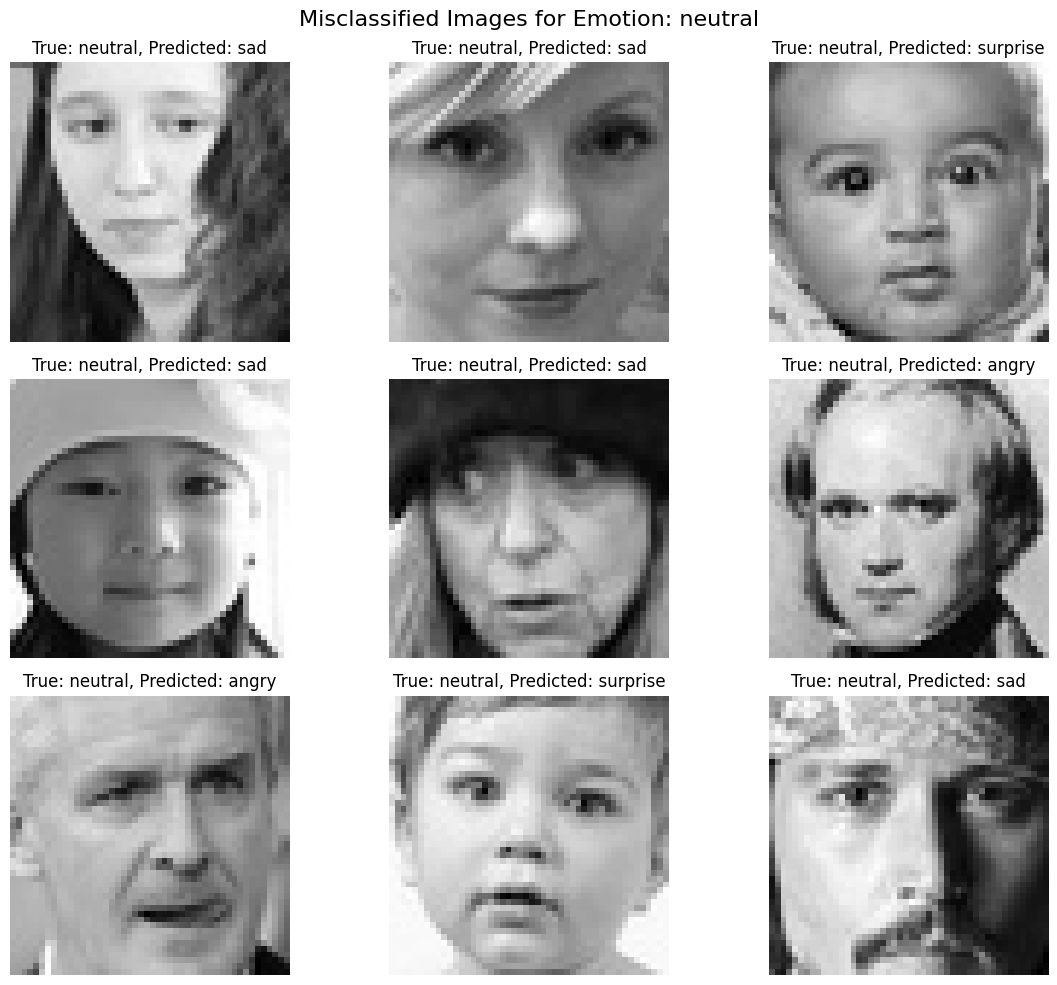

In [33]:
# Get predictions and true labels if not already defined
predictions = np.argmax(emotion_model.predict(test_set), axis=1)
true_labels = test_set.classes

# Specify the emotion you want to focus on (by its index)
emotion_index = 3  # Change this to the index of the desired emotion
emotion_name = list(test_set.class_indices.keys())[emotion_index]  # Get the corresponding emotion name

# Extract the misclassified indices
misclassified_indices = np.where(predictions != true_labels)[0]

# Filter misclassified indices for the specified emotion
misclassified_for_emotion = [idx for idx in misclassified_indices if true_labels[idx] == emotion_index]

# Display misclassified images with true and predicted labels for the specified emotion
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_for_emotion[:9]):  # Display first 9 misclassified images for the specified emotion
    plt.subplot(3, 3, i + 1)

    # Get the batch of images and extract a single image using idx
    img_batch, _ = test_set[idx // test_set.batch_size]  # Adjust to get the correct batch
    img = img_batch[idx % test_set.batch_size]  # Get the correct image from the batch

    true_label = true_labels[idx]
    predicted_label = predictions[idx]

    plt.imshow(img.squeeze(), cmap='gray')  # Remove cmap if images are in RGB
    plt.title(f'True: {list(test_set.class_indices.keys())[true_label]}, Predicted: {list(test_set.class_indices.keys())[predicted_label]}')
    plt.axis('off')

plt.suptitle(f'Misclassified Images for Emotion: {emotion_name}', fontsize=16)
plt.tight_layout()
plt.show()

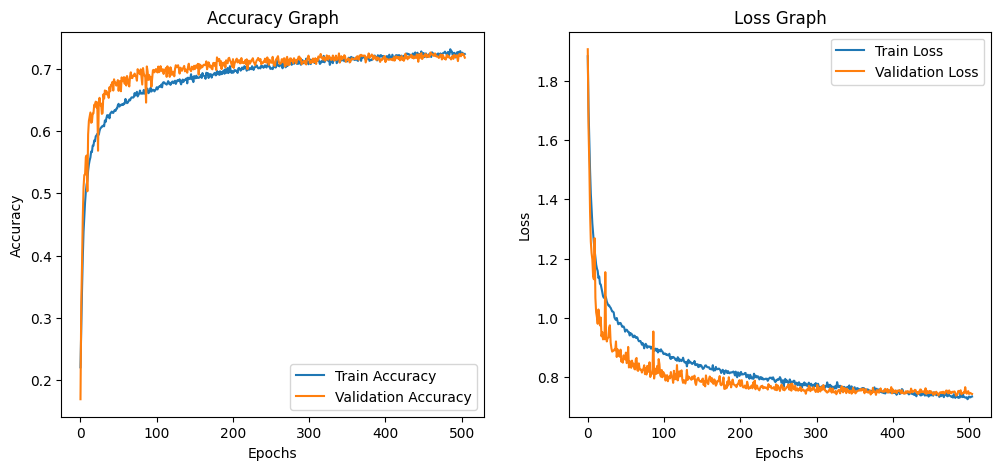

In [34]:
# Load the history data from .pkl files
history_files = ['/kaggle/input/fer-final/training_history_first.pkl', '/kaggle/input/fer-final/training_history_second.pkl', '/kaggle/input/fer-final/training_history_third.pkl', '/kaggle/input/fer-final/training_history_fourth.pkl']
histories = []

# Load each history file into a list
for file in history_files:
    with open(file, 'rb') as f:
        histories.append(pickle.load(f))

# Combine the histories
combined_history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

# Total number of epochs processed so far
total_epochs = 0

for history in histories:
    # Append current history data to combined history
    combined_history['accuracy'].extend(history['accuracy'])
    combined_history['val_accuracy'].extend(history['val_accuracy'])
    combined_history['loss'].extend(history['loss'])
    combined_history['val_loss'].extend(history['val_loss'])
    
    # Update total epochs
    total_epochs += len(history['accuracy'])  # Assuming all histories have the same number of epochs

# Create epoch labels for the combined history
epochs = list(range(total_epochs))

# Plot the Accuracy graph
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, combined_history['accuracy'], label='Train Accuracy')
plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs, combined_history['loss'], label='Train Loss')
plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

72/72 [==============================] - 5s 69ms/step
Confusion matrix, without normalization
[[1872  252   52  368  432   68]
 [ 380 1164   36  348  660  456]
 [  60   60 2668  108   84   64]
 [ 116   28  116 2552  192   40]
 [ 148  144   80  404 2248   20]
 [  72  152   68   72   64 2616]]


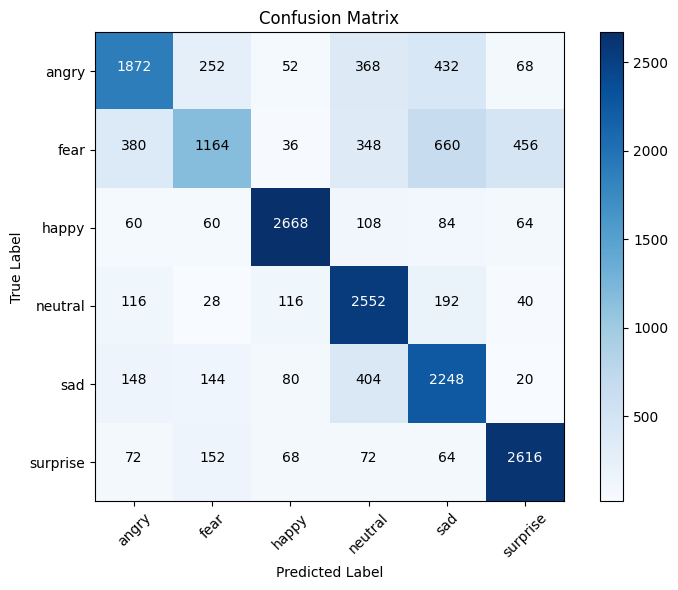

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Load your histories (assuming you have four history files)
history_files = ['/kaggle/input/fer-final/training_history_first.pkl', '/kaggle/input/fer-final/training_history_second.pkl', '/kaggle/input/fer-final/training_history_third.pkl', '/kaggle/input/fer-final/training_history_fourth.pkl']
combined_cm = None  # Initialize combined confusion matrix

for history_file in history_files:
    with open(history_file, 'rb') as file:
        history = pickle.load(file)
    
    # Predict the values from the test dataset
    Y_pred = emotion_model.predict(test_set)
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Compute the confusion matrix for the current history
    cm = confusion_matrix(test_set.classes, y_pred)
    
    # Combine the confusion matrices
    if combined_cm is None:
        combined_cm = cm
    else:
        combined_cm += cm  # Add the current confusion matrix to the combined one

# Plot the combined confusion matrix
plot_confusion_matrix(combined_cm, classes=list(test_set.class_indices.keys()), title='Confusion Matrix')

In [14]:
# Predicting classes for the test set
test_set.reset()  # Ensure correct evaluation
predictions = np.argmax(emotion_model.predict(test_set), axis=1)  # Multi-class prediction

# True labels for the test set
true_labels = test_set.classes  # Already in integer format

72/72 [==============================] - 20s 277ms/step


In [42]:
val_losses = []
val_accuracies = []

# Load each history file and extract the last validation loss and accuracy
for file in history_files:
    with open(file, 'rb') as f:
        history = pickle.load(f)
        val_losses.append(history['val_loss'][-1])  # Last validation loss
        val_accuracies.append(history['val_accuracy'][-1])  # Last validation accuracy

# Calculate average validation loss and accuracy
average_val_loss = np.mean(val_losses)
average_val_accuracy = np.mean(val_accuracies)

# Assuming you have true_labels and predictions defined
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print the desired metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")
print(f"Test Loss: {average_val_loss:.4f}")

Test Accuracy: 71.84%
Weighted Precision: 0.72
Weighted Recall: 0.72
Weighted F1 Score: 0.71
Test Loss: 0.7755
